### Building a Recommender system with Surprise

This try-it focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to grouplens and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.



## Imports

In [2]:
from surprise import (
    Dataset,
    Reader,
    SVD,
    NMF,
    KNNBasic,
    KNNWithMeans,
    SlopeOne,
    CoClustering,
    accuracy,
)
from surprise.model_selection import (
    cross_validate,
    split,
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})

## Data Load

Data source is [here](https://goldberg.berkeley.edu/jester-data/)
- Found it by clicking off from grouplens to Jester

In [3]:
# ! pip install xlrd

In [4]:
if 0:
    df = pd.read_excel("./data/jester-data-1.xls", header=None)
    df.to_csv("./data/jester-data-1.csv", index=False)
else:
    df = pd.read_csv("./data/jester-data-1.csv")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,4.13,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,3.64,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,7.28,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.00,99.00,99.00,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,3.45,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,-0.05,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.00,99.00,99.00,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,100,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,8.74,6.41,-6.36,-4.51,2.04,8.74,3.30,8.01,7.82,-1.89,3.25,2.18,1.26,8.35,3.35,-2.14,-7.91,-6.46,-3.40,5.58,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45

Select only the dense columns
> The sub-matrix including only columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense. Almost all users have rated those jokes...

In [94]:
dense_columns = [str(k) for k in [0, 5, 7, 8, 13, 15, 16, 17, 18, 19, 20]]
if 1:
    df = df[dense_columns]
df

,0,5,7,8,13,15,16,17,18,19,20
0,74,-7.52,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85
1,100,-2.38,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,-1.21
2,49,9.03,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,9.03
3,48,1.80,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,-2.09
4,91,1.36,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,4.51
...,...,...,...,...,...,...,...,...,...,...,...
24978,100,3.20,-8.79,-0.53,-7.14,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46
24979,91,0.87,-3.50,5.78,-7.48,-1.75,6.60,3.54,1.50,7.67,-0.44
24980,39,-7.77,6.70,-6.75,-6.46,-6.80,-6.41,-6.99,7.23,6.75,-6.99
24981,37,-9.71,4.56,-8.30,-9.47,3.45,-0.92,-4.51,-4.13,-5.73,-9.51


Use the index as a user ID column

In [95]:
joke_number_names = {str(k): f"Joke {k:02d}" for k in range(1, 101)}
df.rename(columns={"0": "Number of Jokes Rated"} | joke_number_names, inplace=True)
df

,Number of Jokes Rated,Joke 05,Joke 07,Joke 08,Joke 13,Joke 15,Joke 16,Joke 17,Joke 18,Joke 19,Joke 20
0,74,-7.52,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85
1,100,-2.38,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,-1.21
2,49,9.03,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,9.03
3,48,1.80,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,-2.09
4,91,1.36,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,4.51
...,...,...,...,...,...,...,...,...,...,...,...
24978,100,3.20,-8.79,-0.53,-7.14,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46
24979,91,0.87,-3.50,5.78,-7.48,-1.75,6.60,3.54,1.50,7.67,-0.44
24980,39,-7.77,6.70,-6.75,-6.46,-6.80,-6.41,-6.99,7.23,6.75,-6.99
24981,37,-9.71,4.56,-8.30,-9.47,3.45,-0.92,-4.51,-4.13,-5.73,-9.51


In [96]:
df.insert(loc=0, column="userId", value=df.index)
df

,userId,Number of Jokes Rated,Joke 05,Joke 07,Joke 08,Joke 13,Joke 15,Joke 16,Joke 17,Joke 18,Joke 19,Joke 20
0,0,74,-7.52,-9.85,4.17,-7.18,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85
1,1,100,-2.38,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,-1.21
2,2,49,9.03,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,9.03
3,3,48,1.80,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,-2.09
4,4,91,1.36,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,4.51
...,...,...,...,...,...,...,...,...,...,...,...,...
24978,24978,100,3.20,-8.79,-0.53,-7.14,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46
24979,24979,91,0.87,-3.50,5.78,-7.48,-1.75,6.60,3.54,1.50,7.67,-0.44
24980,24980,39,-7.77,6.70,-6.75,-6.46,-6.80,-6.41,-6.99,7.23,6.75,-6.99
24981,24981,37,-9.71,4.56,-8.30,-9.47,3.45,-0.92,-4.51,-4.13,-5.73,-9.51


Melt the data to turn the joke number into a "title"

In [97]:
df = pd.melt(
    df,
    id_vars="userId",
    value_vars=[_ for _ in df.columns if "Joke " in _],
    var_name="title",
    value_name="rating",
).reset_index(drop=True)
df

,userId,title,rating
0,0,Joke 05,-7.52
1,1,Joke 05,-2.38
2,2,Joke 05,9.03
3,3,Joke 05,1.80
4,4,Joke 05,1.36
...,...,...,...
249825,24978,Joke 20,-6.46
249826,24979,Joke 20,-0.44
249827,24980,Joke 20,-6.99
249828,24981,Joke 20,-9.51


In [98]:
df.sort_values(by=["userId", "title"])

,userId,title,rating
0,0,Joke 05,-7.52
24983,0,Joke 07,-9.85
49966,0,Joke 08,4.17
74949,0,Joke 13,-7.18
99932,0,Joke 15,-7.18
...,...,...,...
149897,24982,Joke 16,-7.77
174880,24982,Joke 17,5.49
199863,24982,Joke 18,1.36
224846,24982,Joke 19,-9.32


Remove ratings of 99 which correspond to no rating

In [99]:
df = df.query("rating != 99").reset_index(drop=True)
df

,userId,title,rating
0,0,Joke 05,-7.52
1,1,Joke 05,-2.38
2,2,Joke 05,9.03
3,3,Joke 05,1.80
4,4,Joke 05,1.36
...,...,...,...
249779,24978,Joke 20,-6.46
249780,24979,Joke 20,-0.44
249781,24980,Joke 20,-6.99
249782,24981,Joke 20,-9.51


Map the rating scale of -10, 10 to 0, 5 - does this matter?

In [100]:
df["rating"] = (df["rating"] + 10.0) / 4
df

,userId,title,rating
0,0,Joke 05,0.6200
1,1,Joke 05,1.9050
2,2,Joke 05,4.7575
3,3,Joke 05,2.9500
4,4,Joke 05,2.8400
...,...,...,...
249779,24978,Joke 20,0.8850
249780,24979,Joke 20,2.3900
249781,24980,Joke 20,0.7525
249782,24981,Joke 20,0.1225


To speed up the development, take a random 10% shuffle of the data

In [101]:
df = df.sample(frac=0.1, random_state=42)
df

,userId,title,rating
138003,13115,Joke 16,3.290
34921,9946,Joke 07,3.690
125715,823,Joke 16,3.750
155742,5877,Joke 17,1.990
45387,20416,Joke 07,2.585
...,...,...,...
196660,21817,Joke 18,0.170
179305,4458,Joke 18,0.400
215185,15364,Joke 19,2.355
186551,11706,Joke 18,1.990


Use prior codio data set to sanity check the results

In [102]:
if 0:
    df = pd.read_csv("./data/movie_ratings.csv", index_col=0).tail(5_000)

Use movielens small data set, as downloaded [from here](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset?select=ratings.csv)

In [10]:
if 1:
    df = pd.read_csv("./data/ratings.csv")
    df.rename(columns={"movieId": "title"}, inplace=True)
df

,userId,title,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## Loop Over Available Algorithms

In [7]:
data = Dataset.load_from_df(df[["userId", "title", "rating"]], Reader())

In [8]:
algo_list = [
    "SVD",
    "NMF",
    # "KNNBasic",  # --> crashing
    "SlopeOne",
    "CoClustering",
]

In [9]:
results_list = []
for algo_name in algo_list:
    print(f"\nRunning algorithm {algo_name}")
    kwargs = {"random_state": 42} if algo_name != "SlopeOne" else {}
    algo = eval(algo_name)(**kwargs)
    cv = split.KFold(random_state=42)
    t0 = time.time()
    cv_results = cross_validate(algo, data, measures=["rmse"], cv=cv, verbose=True)
    results_list.append(
        {
            "Algorithm": algo_name,
            "RMSE": cv_results["test_rmse"].mean(),
            "Fit and Test Time": time.time() - t0,
        }
    )


Running algorithm SVD
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8831  0.8674  0.8630  0.8716  0.8808  0.8732  0.0077  
Fit time          0.78    0.80    0.81    0.77    0.77    0.78    0.02    
Test time         0.09    0.18    0.14    0.17    0.12    0.14    0.03    

Running algorithm NMF
Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9250  0.9153  0.9146  0.9185  0.9265  0.9200  0.0049  
Fit time          2.15    2.05    2.04    2.04    2.02    2.06    0.05    
Test time         0.20    0.07    0.16    0.08    0.08    0.12    0.05    

Running algorithm SlopeOne
Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9080  0.8948  0.8915  0.8951  0.9092  0.8997  0.0074  
Fit time          3.24  

In [11]:
pd.DataFrame(results_list)

,Algorithm,RMSE,Fit and Test Time
0,SVD,0.873179,5.264446
1,NMF,0.920002,11.481812
2,SlopeOne,0.899729,39.793770
3,CoClustering,0.942874,10.909661


## Make Some Plots

Just look at SVD and SlopeOne since those had the best scores and fit times

In [12]:
if 1:
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
else:
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()

In [13]:
def extract_results(surprise_predictions: list) -> tuple[np.array, np.array]:
    return (
        np.array(
            [surprise_predictions[k].r_ui for k in range(len(surprise_predictions))]
        ),
        np.array(
            [surprise_predictions[k].est for k in range(len(surprise_predictions))]
        ),
    )

In [22]:
algo = SVD(random_state=42)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8820


0.8820442070964672

In [15]:
predictions[:1]

[Prediction(uid=50, iid=4282, r_ui=3.5, est=2.690457368689574, details={'was_impossible': False})]

In [35]:
def group_results(y_true, y_pred) -> tuple:
    unique_y_true = np.unique(y_true)
    y_pred_grouped = y_pred.copy() * 0
    for y in unique_y_true:
        mask = y_true == y
        y_pred_grouped[mask] = np.mean(y_pred[mask])
    return y_pred_grouped

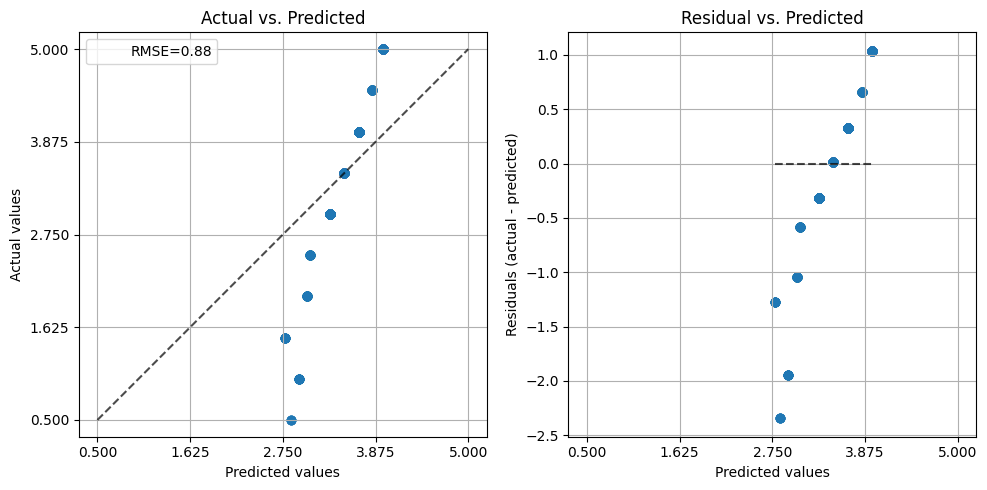

In [36]:
f, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

# plot the actual vs predicted values
y_true, y_pred = extract_results(predictions)
y_pred = group_results(y_true, y_pred)
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)

ax0.set_title("Actual vs. Predicted")

# Add the score in the legend of each axis
ax0.plot([], [], " ", label=f"RMSE={accuracy.rmse(predictions, verbose=False):.2f}")
ax0.legend(loc="upper left")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

ax1.set_title("Residual vs. Predicted")

plt.tight_layout()
plt.show()

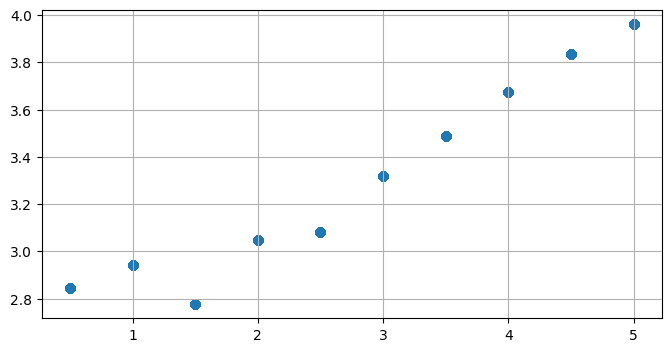

In [37]:
plt.scatter(y_true, y_pred)

## Grid Search

In [114]:
param_grid = {
    "n_factors": [1, 5, 10, 50],
    "n_epochs": [5, 50, 500],
}

if 0:
    gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=5)
    gs.fit(data)

    [
        gs.best_score,
        gs.best_params,
    ]